In [2]:
class Camera:
    def __init__(self, P):
        self.P = P
        self.K, self.R, self.t = self.decompose_projection_matrix(P)

    @staticmethod
    def decompose_projection_matrix(P):
        # Extract the camera matrix (3x3) from P (3x4)
        M = P[:, :3]
        
        # Perform RQ decomposition on the camera matrix M
        K, R = np.linalg.qr(np.linalg.inv(M))
        
        # Adjust the matrices so that the diagonal elements of K are positive
        T = np.diag(np.sign(np.diag(K)))
        K = K @ T
        R = T @ R
        
        # Ensure that K has positive diagonal elements
        if np.linalg.det(R) < 0:
            R = -R
            K = -K
        
        # Compute the translation vector
        t = np.linalg.inv(K) @ P[:, 3]

        # Normalize K so that K[2, 2] == 1
        K /= K[2, 2]

        return K, R, t

    def get_intrinsics(self):
        return self.K

    def get_rotation(self):
        return self.R

    def get_translation(self):
        return self.t

In [3]:
# Example usage:
P = np.array([[1000, 0, 320, 100],
              [0, 1000, 240, 200],
              [0, 0, 1, 1]])

camera = Camera(P)
K = camera.get_intrinsics()
R = camera.get_rotation()
t = camera.get_translation()

print("Intrinsic matrix (K):\n", K)
print("Rotation matrix (R):\n", R)
print("Translation vector (t):\n", t)

Intrinsic matrix (K):
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Rotation matrix (R):
 [[ 0.001  0.    -0.32 ]
 [ 0.     0.001 -0.24 ]
 [ 0.     0.     1.   ]]
Translation vector (t):
 [100. 200.   1.]


In [6]:
from data import read_camera_params
path = 'data/camera_params/'
images_path = 'data/images/'
cameras_params = read_camera_params(path)
cameras = [Camera(cp) for cp in cameras_params]

In [5]:
cameras[0].get_intrinsics()

array([[ 1.00057734e+00, -4.42127040e-04,  1.36591234e-04],
       [ 4.46511737e-04,  9.99999910e-01, -3.39884738e-02],
       [-1.21493841e-04,  3.39885312e-02,  1.00000000e+00]])

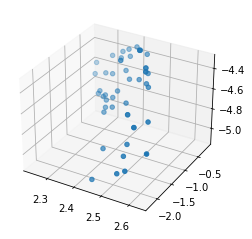

Camera 1 Intrinsic matrix (K):
 [[ 1.00057734e+00 -4.42127040e-04  1.36591234e-04]
 [ 4.46511737e-04  9.99999910e-01 -3.39884738e-02]
 [-1.21493841e-04  3.39885312e-02  1.00000000e+00]]
Camera 1 Rotation matrix (R):
 [[ 1.49907703e-03  4.26172089e-06 -5.99283491e-01]
 [-0.00000000e+00  1.48463774e-03 -3.94859834e-01]
 [-0.00000000e+00 -0.00000000e+00  9.98782048e-01]]
Camera 1 Translation vector (t):
 [ 6.41713830e+01  7.33589183e-01 -3.41247046e-02]
Camera 2 Intrinsic matrix (K):
 [[ 0.99767649  0.06929313 -0.17716573]
 [-0.07260131  1.01297421 -0.01264617]
 [ 0.17583596  0.02508661  1.        ]]
Camera 2 Rotation matrix (R):
 [[ 1.52576378e-03  4.56086830e-06 -6.02284479e-01]
 [-0.00000000e+00  1.53256660e-03 -4.26248454e-01]
 [-0.00000000e+00 -0.00000000e+00  1.01095600e+00]]
Camera 2 Translation vector (t):
 [ 681.62287745   81.16207947 -121.8871832 ]


In [12]:


def detect_and_match_keypoints(self,img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)

    num_matches = 50
    matches = matches[:num_matches]

    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    return points1, points2


# Function to perform triangulation
def triangulate_points(P1, P2, points1, points2):
    points4D = cv2.triangulatePoints(P1, P2, points1.T, points2.T)
    points4D /= points4D[3]
    return points4D

# Load the images
img1 = cv2.imread(images_path + 'house.00' + str(0) + '.pgm')
img2 = cv2.imread(images_path + 'house.00' + str(0) + '.pgm')


P1 = cameras_params[0]
P2 = cameras_params[1]

camera1 = Camera(P1)
camera2 = Camera(P2)

points1, points2 = detect_and_match_keypoints(img1, img2)

points4D = triangulate_points(P1, P2, points1, points2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points4D[0], points4D[1], points4D[2])
plt.show()

# Print the intrinsic, rotation, and translation matrices
print("Camera 1 Intrinsic matrix (K):\n", camera1.get_intrinsics())
print("Camera 1 Rotation matrix (R):\n", camera1.get_rotation())
print("Camera 1 Translation vector (t):\n", camera1.get_translation())

print("Camera 2 Intrinsic matrix (K):\n", camera2.get_intrinsics())
print("Camera 2 Rotation matrix (R):\n", camera2.get_rotation())
print("Camera 2 Translation vector (t):\n", camera2.get_translation())

## Imports

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from lib import 

ModuleNotFoundError: No module named 'lib.py'; 'lib' is not a package

## 0. Setup

In [ ]:
path = 'data/camera_params/'
images_path = 'data/images/'
cameras_params = read_camera_params(path)
cameras = [Camera(cp) for cp in cameras_params]